## Calculate glacier thickness using BedMachine V5

In [43]:
import numpy as np
import pandas as pd
import xarray as xr
import pyresample
from pyproj import Proj, transform, Transformer, CRS
import matplotlib.pyplot as plt

In [4]:
# import BedMachine data
melville_bed = xr.open_dataset('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/BedMachine_v5_regions/bedmachineV5_moorings_region.nc')

In [6]:
rink_ice_front = melville_bed.sel(x=-411797, y=-1440594, method='nearest')
ko_ice_front   = melville_bed.sel(x=-387839.71, y=-1474312.79, method='nearest')
sver_ice_front = melville_bed.sel(x=-354945.04, y=-1526348.37, method='nearest')

In [20]:
print(f'rink ice thickness {rink_ice_front.thickness.values.round()} m')
print(f'rink ice front bathymetry max depth {rink_ice_front.bed.values.round()} m')
print(f'rink glacier surface elevation {rink_ice_front.surface.values.round()} m')

rink ice thickness 286.0 m
rink ice front bathymetry max depth -224.0 m
rink glacier surface elevation 62.0 m


In [21]:
print(f'kong oscar ice thickness {ko_ice_front.thickness.values.round()} m')
print(f'kong oscar ice front bathymetry max depth {ko_ice_front.bed.values.round()} m')
print(f'kong oscar glacier surface elevation {ko_ice_front.surface.values.round()} m')

kong oscar ice thickness 871.0 m
kong oscar ice front bathymetry max depth -754.0 m
kong oscar glacier surface elevation 116.0 m


In [22]:
print(f'sverdrup ice thickness {sver_ice_front.thickness.values.round()} m')
print(f'sverdrup ice front bathymetry max depth {sver_ice_front.bed.values.round()} m')
print(f'sverdrup glacier surface elevation {sver_ice_front.surface.values.round()} m')

sverdrup ice thickness 655.0 m
sverdrup ice front bathymetry max depth -535.0 m
sverdrup glacier surface elevation 120.0 m


### Extract values from entire front (measured as linear distance across front)

Import csv files for three glacier fronts

In [71]:
sver_front = pd.read_csv('D:/Habitat_model_data/QGIS_files/sverdrup_front_points.csv')
ko_front   = pd.read_csv('D:/Habitat_model_data/QGIS_files/kongoscar_front_points.csv')
rink_frontL = pd.read_csv('D:/Habitat_model_data/QGIS_files/rink_front_left_points.csv')
rink_frontR = pd.read_csv('D:/Habitat_model_data/QGIS_files/rink_front_right_points.csv')

In [65]:
# import BedMachine data
melville_bed = xr.open_dataset('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/BedMachine_v5_regions/bedmachineV5_moorings_region.nc')

In [66]:
# Define lat-lon grid
lon_grid_bedmachine = melville_bed.lon.values
lat_grid_bedmachine = melville_bed.lat.values
grid_bedmachine = pyresample.geometry.GridDefinition(lats=lat_grid_bedmachine, lons=lon_grid_bedmachine)

In [67]:
# function that reprojects polar stereographic to lat/lon coordinates
def transform_projection_to_EPSG4326(points_df):
    transformer = Transformer.from_crs('EPSG:3413','EPSG:4326')
    lat, lon = transformer.transform(points_df.x,points_df.y)
    
    return lat,lon

In [72]:
sver_lat, sver_lon = transform_projection_to_EPSG4326(sver_front)
ko_lat, ko_lon = transform_projection_to_EPSG4326(ko_front)
rink_lat_L, rink_lon_L = transform_projection_to_EPSG4326(rink_frontL)
rink_lat_R, rink_lon_R = transform_projection_to_EPSG4326(rink_frontR)

In [78]:
def get_glacier_front_properties(line_df, line_longitude, line_latitude, melville_bed, grid_bedmachine):
    # find nearest neighbor lat/lon values from bedmachine data using normal line lat/lon swaths
    swath = pyresample.geometry.SwathDefinition(lons=line_longitude, lats=line_latitude)
        
    # Determine nearest (w.r.t. great circle distance) neighbour in the grid.
    _, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
        source_geo_def=grid_bedmachine, target_geo_def=swath, radius_of_influence=250,neighbours=1)
        
    # get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
    index_array_2d = np.unravel_index(index_array, grid_bedmachine.shape)
    
    # get search line lat/lons
    lat_line = lat_grid_bedmachine[index_array_2d][:] # lat points for line along which I select the max elevation
    lon_line = lon_grid_bedmachine[index_array_2d][:] # lon points for line along which I select the max elevation
    # get desired values along search line
    bathy_line = np.array(melville_bed.bed.values[index_array_2d])
    surface_line = np.array(melville_bed.surface.values[index_array_2d])
    thickness_line = np.array(melville_bed.thickness.values[index_array_2d])
    
    print('Max depth/grounding line: ', bathy_line.min())
    print('Mean ice front surface elevation: ', surface_line.mean())
    print('Max ice front thickness: ', thickness_line.max())
    
    plt.plot(line_df.distance, bathy_line, label='bathymetry')
    plt.plot(line_df.distance, surface_line, label='surface')
    plt.plot(line_df.distance, thickness_line, label='ice thickness')
    plt.xlabel('running distance along glacier front (m)')
    plt.ylabel('meters')
    plt.legend();
    plt.show()
    
    return bathy_line, surface_line, thickness_line

#### Sverdrup

Max depth/grounding line:  -531.904
Mean ice front surface elevation:  149.57585
Max ice front thickness:  659.9205


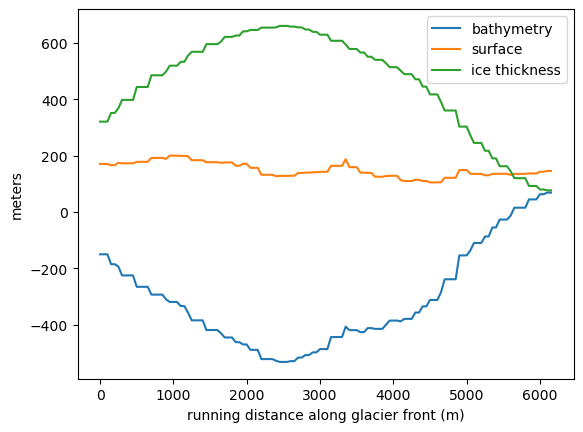

In [95]:
sver_bathy_line, sver_surface_line, sver_thickness_line = get_glacier_front_properties(sver_front, sver_lon, sver_lat, melville_bed, grid_bedmachine)

#### Kong Oscar

Max depth/grounding line:  -754.09576
Mean ice front surface elevation:  119.827354
Max ice front thickness:  873.58417


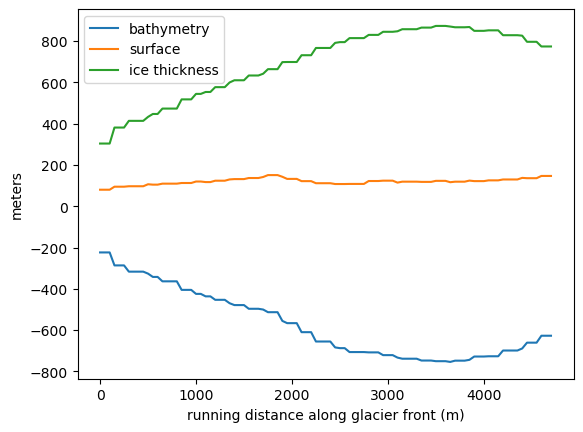

In [93]:
ko_bathy_line, ko_surface_line, ko_thickness_line = get_glacier_front_properties(ko_front, ko_lon, ko_lat, melville_bed, grid_bedmachine)

#### Rink

Max depth/grounding line:  -114.19041
Mean ice front surface elevation:  169.34097
Max ice front thickness:  238.23746


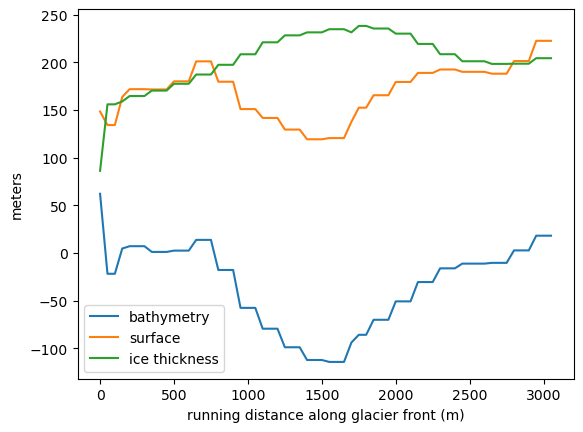

In [94]:
rinkL_bathy_line, rinkL_surface_line, rinkL_thickness_line = get_glacier_front_properties(rink_frontL, rink_lon_L, rink_lat_L, melville_bed, grid_bedmachine)

Max depth/grounding line:  -223.3732
Mean ice front surface elevation:  117.69582
Max ice front thickness:  327.56055


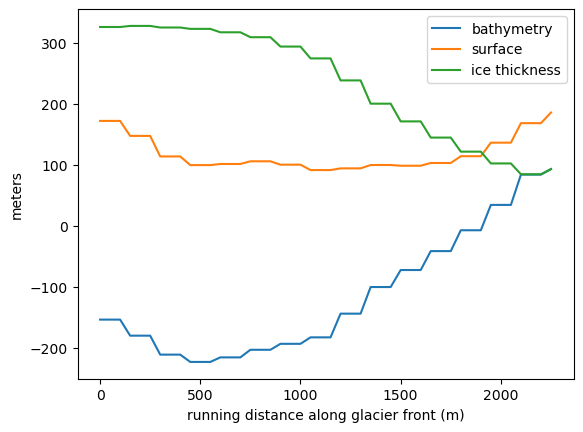

In [82]:
rinkR_bathy_line, rinkR_surface_line, rinkR_thickness_line = get_glacier_front_properties(rink_frontR, rink_lon_R, rink_lat_R, melville_bed, grid_bedmachine)

In [92]:
# calculate values across both rink glaciers
print('grounding line depth: ', np.concatenate((rinkL_bathy_line, rinkR_bathy_line)).min())
print('mean surface elvation: ', np.concatenate((rinkL_surface_line, rinkR_surface_line)).mean())
print('max ice thickness: ', np.concatenate((rinkL_thickness_line, rinkR_thickness_line)).max())

grounding line depth:  -223.3732
mean surface elvation:  147.34401
max ice thickness:  327.56055
